In [1]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
cd drive/My\ Drive/RGCN

/content/drive/My Drive/RGCN


In [ ]:
!ls data/mydata

entityDict.json  test.txt（副本）  train.txt（副本）  valid.txt（副本）


In [ ]:
import json
with open('data/mydata/entityDict.json','r',encoding='utf8')as fp:
    json_data = json.load(fp)

In [ ]:
print(len())

59371


In [ ]:
with open('data/mydata/entity.dict', 'w+', encoding='utf8') as fp:
  for key in json_data['stoi']:
    fp.write(str(json_data['stoi'][key])+"\t"+key+"\n")

In [4]:
!pip install torch-scatter -f https://data.pyg.org/whl/torch-1.10.0+cu111.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-1.10.0+cu111.html
!pip install torch-geometric
!pip install torch-cluster -f https://data.pyg.org/whl/torch-1.10.0+cu111.html
!pip install torch-spline-conv -f https://data.pyg.org/whl/torch-1.10.0+cu111.html

Looking in links: https://data.pyg.org/whl/torch-1.10.0+cu111.html
     |████████████████████████████████| 7.9 MB 56.9 MB/s 
Looking in links: https://data.pyg.org/whl/torch-1.10.0+cu111.html
     |████████████████████████████████| 3.5 MB 33.1 MB/s 
     |████████████████████████████████| 407 kB 33.3 MB/s 
  Created wheel for torch-geometric: filename=torch_geometric-2.0.4-py3-none-any.whl size=616603 sha256=7375e21ce35505fd36ac0fa9e399a0247f802fbf03bd481eadd6cbfa652b7619
  Stored in directory: /root/.cache/pip/wheels/18/a6/a4/ca18c3051fcead866fe7b85700ee2240d883562a1bc70ce421
Successfully built torch-geometric
Looking in links: https://data.pyg.org/whl/torch-1.10.0+cu111.html
     |████████████████████████████████| 2.5 MB 34.8 MB/s 
Looking in links: https://data.pyg.org/whl/torch-1.10.0+cu111.html
     |████████████████████████████████| 750 kB 46.6 MB/s 


In [ ]:
!python main.py --gpu=0  --graph-batch-size=1024

Namespace(dropout=0.2, evaluate_every=500, gpu=0, grad_norm=1.0, graph_batch_size=1024, graph_split_size=0.5, lr=0.01, n_bases=4, n_epochs=10000, negative_sample=1, regularization=0.01)
load data from ./data/mydata
num_entity: 59371
num_relation: 1
num_train_triples: 410781
num_valid_triples: 64470
num_test_triples: 175182
RGCN(
  (entity_embedding): Embedding(59371, 100)
  (conv1): RGCNConv(100, 100, num_relations=2)
  (conv2): RGCNConv(100, 100, num_relations=2)
)
Train Loss 0.3722216784954071 at epoch 500
Train Loss 0.31493157148361206 at epoch 1000
Train Loss 0.3098926246166229 at epoch 1500
Train Loss 0.2930219769477844 at epoch 2000
Train Loss 0.2873312830924988 at epoch 2500
Train Loss 0.30563974380493164 at epoch 3000
Train Loss 0.27985280752182007 at epoch 3500
Train Loss 0.3140754997730255 at epoch 4000
Train Loss 0.28352057933807373 at epoch 4500
Train Loss 0.2839602530002594 at epoch 5000
Train Loss 0.2991601228713989 at epoch 5500
Train Loss 0.28758570551872253 at epoch 60

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn.conv import MessagePassing

import os
import math
import numpy as np
import torch
import torch.nn.functional as F
from tqdm import tqdm
from torch_scatter import scatter_add
from torch_geometric.data import Data

def uniform(size, tensor):
    bound = 1.0 / math.sqrt(size)
    if tensor is not None:
        tensor.data.uniform_(-bound, bound)

def load_data(file_path):
    '''
        argument:
            file_path: ./data/FB15k-237
        
        return:
            entity2id, relation2id, train_triplets, valid_triplets, test_triplets
    '''

    print("load data from {}".format(file_path))

    with open(os.path.join(file_path, 'entities.dict')) as f:
        entity2id = dict()

        for line in f:
            eid, entity = line.strip().split('\t')
            entity2id[entity] = int(eid)

    with open(os.path.join(file_path, 'relations.dict')) as f:
        relation2id = dict()

        for line in f:
            rid, relation = line.strip().split('\t')
            relation2id[relation] = int(rid)

    train_triplets = read_triplets(os.path.join(file_path, 'train.txt'), entity2id, relation2id)
    valid_triplets = read_triplets(os.path.join(file_path, 'valid.txt'), entity2id, relation2id)
    test_triplets = read_triplets(os.path.join(file_path, 'test.txt'), entity2id, relation2id)

    print('num_entity: {}'.format(len(entity2id)))
    print('num_relation: {}'.format(len(relation2id)))
    print('num_train_triples: {}'.format(len(train_triplets)))
    print('num_valid_triples: {}'.format(len(valid_triplets)))
    print('num_test_triples: {}'.format(len(test_triplets)))

    return entity2id, relation2id, train_triplets, valid_triplets, test_triplets

def read_triplets(file_path, entity2id, relation2id):
    triplets = []

    with open(file_path) as f:
        for line in f:
            head, relation, tail = line.strip().split('\t')
            triplets.append((entity2id[head], relation2id[relation], entity2id[tail]))

    return np.array(triplets)

def sample_edge_uniform(n_triples, sample_size):
    """Sample edges uniformly from all the edges."""
    all_edges = np.arange(n_triples)
    return np.random.choice(all_edges, sample_size, replace=False)

def negative_sampling(pos_samples, num_entity, negative_rate):
    size_of_batch = len(pos_samples)
    num_to_generate = size_of_batch * negative_rate
    neg_samples = np.tile(pos_samples, (negative_rate, 1))
    labels = np.zeros(size_of_batch * (negative_rate + 1), dtype=np.float32)
    labels[: size_of_batch] = 1
    values = np.random.choice(num_entity, size=num_to_generate)
    choices = np.random.uniform(size=num_to_generate)
    subj = choices > 0.5
    obj = choices <= 0.5
    neg_samples[subj, 0] = values[subj]
    neg_samples[obj, 2] = values[obj]

    return np.concatenate((pos_samples, neg_samples)), labels

def edge_normalization(edge_type, edge_index, num_entity, num_relation):
    '''
        Edge normalization trick
        - one_hot: (num_edge, num_relation)
        - deg: (num_node, num_relation)
        - index: (num_edge)
        - deg[edge_index[0]]: (num_edge, num_relation)
        - edge_norm: (num_edge)
    '''
    one_hot = F.one_hot(edge_type, num_classes = 2 * num_relation).to(torch.float)
    deg = scatter_add(one_hot, edge_index[0], dim = 0, dim_size = num_entity)
    index = edge_type + torch.arange(len(edge_index[0])) * (2 * num_relation)
    edge_norm = 1 / deg[edge_index[0]].view(-1)[index]

    return edge_norm

def generate_sampled_graph_and_labels(triplets, sample_size, split_size, num_entity, num_rels, negative_rate):
    """
        Get training graph and signals
        First perform edge neighborhood sampling on graph, then perform negative
        sampling to generate negative samples
    """

    edges = sample_edge_uniform(len(triplets), sample_size)

    # Select sampled edges
    edges = triplets[edges]
    src, rel, dst = edges.transpose()
    uniq_entity, edges = np.unique((src, dst), return_inverse=True)
    src, dst = np.reshape(edges, (2, -1))
    relabeled_edges = np.stack((src, rel, dst)).transpose()

    # Negative sampling
    samples, labels = negative_sampling(relabeled_edges, len(uniq_entity), negative_rate)

    # further split graph, only half of the edges will be used as graph
    # structure, while the rest half is used as unseen positive samples
    split_size = int(sample_size * split_size)
    graph_split_ids = np.random.choice(np.arange(sample_size),
                                       size=split_size, replace=False)

    src = torch.tensor(src[graph_split_ids], dtype = torch.long).contiguous()
    dst = torch.tensor(dst[graph_split_ids], dtype = torch.long).contiguous()
    rel = torch.tensor(rel[graph_split_ids], dtype = torch.long).contiguous()

    # Create bi-directional graph
    src, dst = torch.cat((src, dst)), torch.cat((dst, src))
    rel = torch.cat((rel, rel + num_rels))

    edge_index = torch.stack((src, dst))
    edge_type = rel

    data = Data(edge_index = edge_index)
    data.entity = torch.from_numpy(uniq_entity)
    data.edge_type = edge_type
    data.edge_norm = edge_normalization(edge_type, edge_index, len(uniq_entity), num_rels)
    data.samples = torch.from_numpy(samples)
    data.labels = torch.from_numpy(labels)

    return data

def build_test_graph(num_nodes, num_rels, triplets):
    src, rel, dst = triplets.transpose()

    src = torch.from_numpy(src)
    rel = torch.from_numpy(rel)
    dst = torch.from_numpy(dst)

    src, dst = torch.cat((src, dst)), torch.cat((dst, src))
    rel = torch.cat((rel, rel + num_rels))

    edge_index = torch.stack((src, dst))
    edge_type = rel

    data = Data(edge_index = edge_index)
    data.entity = torch.from_numpy(np.arange(num_nodes))
    data.edge_type = edge_type
    data.edge_norm = edge_normalization(edge_type, edge_index, num_nodes, num_rels)

    return data

def sort_and_rank(score, target):
    _, indices = torch.sort(score, dim=1, descending=True)
    indices = torch.nonzero(indices == target.view(-1, 1))
    indices = indices[:, 1].view(-1)
    return indices

# return MRR (filtered), and Hits @ (1, 3, 10)
def calc_mrr(embedding, w, test_triplets, all_triplets, hits=[]):
    with torch.no_grad():
        
        num_entity = len(embedding)

        ranks_s = []
        ranks_o = []

        head_relation_triplets = all_triplets[:, :2]
        tail_relation_triplets = torch.stack((all_triplets[:, 2], all_triplets[:, 1])).transpose(0, 1)

        for test_triplet in tqdm(test_triplets):

            # Perturb object
            subject = test_triplet[0]
            relation = test_triplet[1]
            object_ = test_triplet[2]

            subject_relation = test_triplet[:2]
            delete_index = torch.sum(head_relation_triplets == subject_relation, dim = 1)
            delete_index = torch.nonzero(delete_index == 2).squeeze()

            delete_entity_index = all_triplets[delete_index, 2].view(-1).numpy()
            perturb_entity_index = np.array(list(set(np.arange(num_entity)) - set(delete_entity_index)))
            perturb_entity_index = torch.from_numpy(perturb_entity_index)
            perturb_entity_index = torch.cat((perturb_entity_index, object_.view(-1)))
            
            emb_ar = embedding[subject] * w[relation]
            emb_ar = emb_ar.view(-1, 1, 1)

            emb_c = embedding[perturb_entity_index]
            emb_c = emb_c.transpose(0, 1).unsqueeze(1)
            
            out_prod = torch.bmm(emb_ar, emb_c)
            score = torch.sum(out_prod, dim = 0)
            score = torch.sigmoid(score)
            
            target = torch.tensor(len(perturb_entity_index) - 1)
            ranks_s.append(sort_and_rank(score, target))

            # Perturb subject
            object_ = test_triplet[2]
            relation = test_triplet[1]
            subject = test_triplet[0]

            object_relation = torch.tensor([object_, relation])
            delete_index = torch.sum(tail_relation_triplets == object_relation, dim = 1)
            delete_index = torch.nonzero(delete_index == 2).squeeze()

            delete_entity_index = all_triplets[delete_index, 0].view(-1).numpy()
            perturb_entity_index = np.array(list(set(np.arange(num_entity)) - set(delete_entity_index)))
            perturb_entity_index = torch.from_numpy(perturb_entity_index)
            perturb_entity_index = torch.cat((perturb_entity_index, subject.view(-1)))

            emb_ar = embedding[object_] * w[relation]
            emb_ar = emb_ar.view(-1, 1, 1)

            emb_c = embedding[perturb_entity_index]
            emb_c = emb_c.transpose(0, 1).unsqueeze(1)

            out_prod = torch.bmm(emb_ar, emb_c)
            score = torch.sum(out_prod, dim = 0)
            score = torch.sigmoid(score)

            target = torch.tensor(len(perturb_entity_index) - 1)
            ranks_o.append(sort_and_rank(score, target))

        ranks_s = torch.cat(ranks_s)
        ranks_o = torch.cat(ranks_o)

        ranks = torch.cat([ranks_s, ranks_o])
        ranks += 1 # change to 1-indexed

        mrr = torch.mean(1.0 / ranks.float())
        print("MRR (filtered): {:.6f}".format(mrr.item()))

        for hit in hits:
            avg_count = torch.mean((ranks <= hit).float())
            print("Hits (filtered) @ {}: {:.6f}".format(hit, avg_count.item()))
            
    return mrr.item()

class RGCN(torch.nn.Module):
    def __init__(self, num_entities, num_relations, num_bases, dropout):
        super(RGCN, self).__init__()

        self.entity_embedding = nn.Embedding(num_entities, 100)
        self.relation_embedding = nn.Parameter(torch.Tensor(num_relations, 100))

        nn.init.xavier_uniform_(self.relation_embedding, gain=nn.init.calculate_gain('relu'))

        self.conv1 = RGCNConv(
            100, 100, num_relations * 2, num_bases=num_bases)
        self.conv2 = RGCNConv(
            100, 100, num_relations * 2, num_bases=num_bases)

        self.dropout_ratio = dropout

    def forward(self, entity, edge_index, edge_type, edge_norm):
        x = self.entity_embedding(entity)
        x = F.relu(self.conv1(x, edge_index, edge_type, edge_norm))
        x = F.dropout(x, p = self.dropout_ratio, training = self.training)
        x = self.conv2(x, edge_index, edge_type, edge_norm)
        
        return x

    def distmult(self, embedding, triplets):
        s = embedding[triplets[:,0]]
        r = self.relation_embedding[triplets[:,1]]
        o = embedding[triplets[:,2]]
        score = torch.sum(s * r * o, dim=1)
        
        return score

    def score_loss(self, embedding, triplets, target):
        score = self.distmult(embedding, triplets)

        return F.binary_cross_entropy_with_logits(score, target)

    def reg_loss(self, embedding):
        return torch.mean(embedding.pow(2)) + torch.mean(self.relation_embedding.pow(2))

class RGCNConv(MessagePassing):
    r"""The relational graph convolutional operator from the `"Modeling
    Relational Data with Graph Convolutional Networks"
    <https://arxiv.org/abs/1703.06103>`_ paper

    .. math::
        \mathbf{x}^{\prime}_i = \mathbf{\Theta}_{\textrm{root}} \cdot
        \mathbf{x}_i + \sum_{r \in \mathcal{R}} \sum_{j \in \mathcal{N}_r(i)}
        \frac{1}{|\mathcal{N}_r(i)|} \mathbf{\Theta}_r \cdot \mathbf{x}_j,

    where :math:`\mathcal{R}` denotes the set of relations, *i.e.* edge types.
    Edge type needs to be a one-dimensional :obj:`torch.long` tensor which
    stores a relation identifier
    :math:`\in \{ 0, \ldots, |\mathcal{R}| - 1\}` for each edge.

    Args:
        in_channels (int): Size of each input sample.
        out_channels (int): Size of each output sample.
        num_relations (int): Number of relations.
        num_bases (int): Number of bases used for basis-decomposition.
        root_weight (bool, optional): If set to :obj:`False`, the layer will
            not add transformed root node features to the output.
            (default: :obj:`True`)
        bias (bool, optional): If set to :obj:`False`, the layer will not learn
            an additive bias. (default: :obj:`True`)
        **kwargs (optional): Additional arguments of
            :class:`torch_geometric.nn.conv.MessagePassing`.
    """

    def __init__(self, in_channels, out_channels, num_relations, num_bases,
                 root_weight=True, bias=True, **kwargs):
        super(RGCNConv, self).__init__(aggr='mean', **kwargs)

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.num_relations = num_relations
        self.num_bases = num_bases

        self.basis = nn.Parameter(torch.Tensor(num_bases, in_channels, out_channels))
        self.att = nn.Parameter(torch.Tensor(num_relations, num_bases))

        if root_weight:
            self.root = nn.Parameter(torch.Tensor(in_channels, out_channels))
        else:
            self.register_parameter('root', None)

        if bias:
            self.bias = nn.Parameter(torch.Tensor(out_channels))
        else:
            self.register_parameter('bias', None)

        self.reset_parameters()

    def reset_parameters(self):
        size = self.num_bases * self.in_channels
        uniform(size, self.basis)
        uniform(size, self.att)
        uniform(size, self.root)
        uniform(size, self.bias)


    def forward(self, x, edge_index, edge_type, edge_norm=None, size=None):
        """"""
        return self.propagate(edge_index, size=size, x=x, edge_type=edge_type,
                              edge_norm=edge_norm)


    def message(self, x_j, edge_index_j, edge_type, edge_norm):
        w = torch.matmul(self.att, self.basis.view(self.num_bases, -1))

        # If no node features are given, we implement a simple embedding
        # loopkup based on the target node index and its edge type.
        if x_j is None:
            w = w.view(-1, self.out_channels)
            index = edge_type * self.in_channels + edge_index_j
            out = torch.index_select(w, 0, index)
        else:
            w = w.view(self.num_relations, self.in_channels, self.out_channels)
            w = torch.index_select(w, 0, edge_type)
            out = torch.bmm(x_j.unsqueeze(1), w).squeeze(-2)

        return out if edge_norm is None else out * edge_norm.view(-1, 1)

    def update(self, aggr_out, x):
        if self.root is not None:
            if x is None:
                out = aggr_out + self.root
            else:
                out = aggr_out + torch.matmul(x, self.root)

        if self.bias is not None:
            out = out + self.bias
        return out

    def __repr__(self):
        return '{}({}, {}, num_relations={})'.format(
            self.__class__.__name__, self.in_channels, self.out_channels,
            self.num_relations)
        
import argparse
import numpy as np
import torch
import torch.nn as nn
from tqdm import tqdm, trange

from utils import load_data, generate_sampled_graph_and_labels, build_test_graph, calc_mrr
from models import RGCN

def train(train_triplets, model, use_cuda, batch_size, split_size, negative_sample, reg_ratio, num_entities, num_relations):

    train_data = generate_sampled_graph_and_labels(train_triplets, batch_size, split_size, num_entities, num_relations, negative_sample)

    if use_cuda:
        device = torch.device('cuda')
        train_data.to(device)

    entity_embedding = model(train_data.entity, train_data.edge_index, train_data.edge_type, train_data.edge_norm)
    loss = model.score_loss(entity_embedding, train_data.samples, train_data.labels) + reg_ratio * model.reg_loss(entity_embedding)

    return loss

def valid(valid_triplets, model, test_graph, all_triplets):

    entity_embedding = model(test_graph.entity, test_graph.edge_index, test_graph.edge_type, test_graph.edge_norm)
    mrr = calc_mrr(entity_embedding, model.relation_embedding, valid_triplets, all_triplets, hits=[1, 3, 10])

    return mrr

def test(test_triplets, model, test_graph, all_triplets):

    entity_embedding = model(test_graph.entity, test_graph.edge_index, test_graph.edge_type, test_graph.edge_norm)
    mrr = calc_mrr(entity_embedding, model.relation_embedding, test_triplets, all_triplets, hits=[1, 3, 10])

    return mrr


            # if use_cuda:
            #     model.cpu()

            # model.eval()
            # valid_mrr = valid(valid_triplets, model, test_graph, all_triplets)
            
            # if valid_mrr > best_mrr:
            #     best_mrr = valid_mrr
            #     torch.save({'state_dict': model.state_dict(), 'epoch': epoch},
            #                 'best_mrr_model.pth')

            # if use_cuda:
            #     model.cuda()
    
    # if use_cuda:
    #     model.cpu()

    # model.eval()

    # checkpoint = torch.load('best_mrr_model.pth')
    # model.load_state_dict(checkpoint['state_dict'])

    # test(test_triplets, model, test_graph, all_triplets)

def mainnn():
    parser = argparse.ArgumentParser(description='RGCN')
    
    parser.add_argument("--graph-batch-size", type=int, default=30000)
    parser.add_argument("--graph-split-size", type=float, default=0.5)
    parser.add_argument("--negative-sample", type=int, default=1)
    parser.add_argument("--n-epochs", type=int, default=10000)
    parser.add_argument("--evaluate-every", type=int, default=500)
    
    parser.add_argument("--dropout", type=float, default=0.2)
    parser.add_argument("--gpu", type=int, default=-1)
    parser.add_argument("--lr", type=float, default=1e-2)
    parser.add_argument("--n-bases", type=int, default=4)
    
    parser.add_argument("--regularization", type=float, default=1e-2)
    parser.add_argument("--grad-norm", type=float, default=1.0)

    args = parser.parse_args()
    # print(args)

    main(args)
class Arg():
  def __init__(self):
    self.gpu = 0
    self.evaluate_every = 100
    self.n_bases =4
    self.dropout =0.2
    self.lr = 0.01
    self.regularization = 0.01
    self.grad_norm = 1
    self.n_epochs = 5000
    self.graph_batch_size = 1024
    self.graph_split_size = 0.5
    self.negative_sample = 1


arg = Arg()

# main(arg)

In [7]:
a = {'gpu':0, }
a.gpu

AttributeError: ignored

In [4]:
    args = Arg()
    use_cuda = args.gpu >= 0 and torch.cuda.is_available()
    if use_cuda:
        torch.cuda.set_device(args.gpu)

    best_mrr = 0

    entity2id, relation2id, train_triplets, valid_triplets, test_triplets = load_data('./data/mydata')
    all_triplets = torch.LongTensor(np.concatenate((train_triplets, valid_triplets, test_triplets)))

    test_graph = build_test_graph(len(entity2id), len(relation2id), train_triplets)
    valid_triplets = torch.LongTensor(valid_triplets)
    test_triplets = torch.LongTensor(test_triplets)
    
    model = RGCN(len(entity2id), len(relation2id), num_bases=args.n_bases, dropout=args.dropout)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

    print(model)

    if use_cuda:
        model.cuda()
    losses = []
    for epoch in trange(1, (args.n_epochs + 1), desc='Epochs', position=0):

        model.train()
        optimizer.zero_grad()

        loss = train(train_triplets, model, use_cuda, batch_size=args.graph_batch_size, split_size=args.graph_split_size, 
            negative_sample=args.negative_sample, reg_ratio = args.regularization, num_entities=len(entity2id), num_relations=len(relation2id))
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), args.grad_norm)
        optimizer.step()

        if epoch % args.evaluate_every == 0:
            losses.append
            tqdm.write("Train Loss {} at epoch {}".format(loss, epoch))

load data from ./data/mydata
num_entity: 59371
num_relation: 1
num_train_triples: 410781
num_valid_triples: 64470
num_test_triples: 175182
RGCN(
  (entity_embedding): Embedding(59371, 100)
  (conv1): RGCNConv(100, 100, num_relations=2)
  (conv2): RGCNConv(100, 100, num_relations=2)
)


Epochs:   2%|▏         | 107/5000 [00:01<01:19, 61.17it/s]

Train Loss 0.43653666973114014 at epoch 100


Epochs:   4%|▍         | 205/5000 [00:03<01:17, 61.57it/s]

Train Loss 0.4266725480556488 at epoch 200


Epochs:   6%|▌         | 310/5000 [00:04<01:14, 62.82it/s]

Train Loss 0.4080345630645752 at epoch 300


Epochs:   8%|▊         | 408/5000 [00:06<01:12, 63.26it/s]

Train Loss 0.3805466294288635 at epoch 400


Epochs:  10%|█         | 513/5000 [00:08<01:11, 62.91it/s]

Train Loss 0.355291485786438 at epoch 500


Epochs:  12%|█▏        | 611/5000 [00:09<01:10, 62.28it/s]

Train Loss 0.32285577058792114 at epoch 600


Epochs:  14%|█▍        | 709/5000 [00:11<01:07, 63.69it/s]

Train Loss 0.3296861946582794 at epoch 700


Epochs:  16%|█▌        | 807/5000 [00:12<01:06, 62.83it/s]

Train Loss 0.34441348910331726 at epoch 800


Epochs:  18%|█▊        | 912/5000 [00:14<01:05, 62.43it/s]

Train Loss 0.33023086190223694 at epoch 900


Epochs:  20%|██        | 1010/5000 [00:16<01:04, 62.27it/s]

Train Loss 0.3282451331615448 at epoch 1000


Epochs:  22%|██▏       | 1108/5000 [00:17<01:04, 60.48it/s]

Train Loss 0.32166168093681335 at epoch 1100


Epochs:  24%|██▍       | 1206/5000 [00:19<01:01, 61.61it/s]

Train Loss 0.31985732913017273 at epoch 1200


Epochs:  26%|██▌       | 1310/5000 [00:20<01:00, 60.86it/s]

Train Loss 0.3160340487957001 at epoch 1300


Epochs:  28%|██▊       | 1408/5000 [00:22<01:00, 59.54it/s]

Train Loss 0.31908300518989563 at epoch 1400


Epochs:  30%|███       | 1506/5000 [00:24<00:59, 58.97it/s]

Train Loss 0.32514864206314087 at epoch 1500


Epochs:  32%|███▏      | 1611/5000 [00:25<00:56, 59.77it/s]

Train Loss 0.2974843382835388 at epoch 1600


Epochs:  34%|███▍      | 1709/5000 [00:27<00:52, 62.58it/s]

Train Loss 0.31333476305007935 at epoch 1700


Epochs:  36%|███▌      | 1807/5000 [00:29<00:50, 63.15it/s]

Train Loss 0.3026112914085388 at epoch 1800


Epochs:  38%|███▊      | 1912/5000 [00:30<00:49, 62.90it/s]

Train Loss 0.2892218232154846 at epoch 1900


Epochs:  40%|████      | 2010/5000 [00:32<00:48, 62.08it/s]

Train Loss 0.285067081451416 at epoch 2000


Epochs:  42%|████▏     | 2108/5000 [00:33<00:46, 62.00it/s]

Train Loss 0.2958071231842041 at epoch 2100


Epochs:  44%|████▍     | 2206/5000 [00:35<00:44, 63.24it/s]

Train Loss 0.2983555197715759 at epoch 2200


Epochs:  46%|████▌     | 2311/5000 [00:37<00:42, 62.96it/s]

Train Loss 0.28571590781211853 at epoch 2300


Epochs:  48%|████▊     | 2409/5000 [00:38<00:41, 62.78it/s]

Train Loss 0.2885723114013672 at epoch 2400


Epochs:  50%|█████     | 2507/5000 [00:40<00:39, 62.46it/s]

Train Loss 0.3236345946788788 at epoch 2500


Epochs:  52%|█████▏    | 2612/5000 [00:41<00:37, 63.05it/s]

Train Loss 0.3130703866481781 at epoch 2600


Epochs:  54%|█████▍    | 2711/5000 [00:44<00:54, 42.29it/s]

Train Loss 0.316870778799057 at epoch 2700


Epochs:  56%|█████▌    | 2810/5000 [00:46<00:36, 60.55it/s]

Train Loss 0.28779137134552 at epoch 2800


Epochs:  58%|█████▊    | 2908/5000 [00:47<00:33, 62.58it/s]

Train Loss 0.2986792027950287 at epoch 2900


Epochs:  60%|██████    | 3013/5000 [00:49<00:31, 63.43it/s]

Train Loss 0.30329668521881104 at epoch 3000


Epochs:  62%|██████▏   | 3111/5000 [00:50<00:29, 63.31it/s]

Train Loss 0.3164387345314026 at epoch 3100


Epochs:  64%|██████▍   | 3209/5000 [00:52<00:28, 62.91it/s]

Train Loss 0.3091527819633484 at epoch 3200


Epochs:  66%|██████▌   | 3307/5000 [00:53<00:26, 63.19it/s]

Train Loss 0.30814701318740845 at epoch 3300


Epochs:  68%|██████▊   | 3412/5000 [00:55<00:24, 63.93it/s]

Train Loss 0.3094116151332855 at epoch 3400


Epochs:  70%|███████   | 3510/5000 [00:57<00:23, 64.65it/s]

Train Loss 0.27832454442977905 at epoch 3500


Epochs:  72%|███████▏  | 3608/5000 [00:58<00:22, 62.47it/s]

Train Loss 0.28930190205574036 at epoch 3600


Epochs:  74%|███████▍  | 3706/5000 [01:00<00:20, 62.50it/s]

Train Loss 0.30587947368621826 at epoch 3700


Epochs:  76%|███████▌  | 3811/5000 [01:01<00:19, 62.46it/s]

Train Loss 0.2929273545742035 at epoch 3800


Epochs:  78%|███████▊  | 3909/5000 [01:03<00:17, 63.58it/s]

Train Loss 0.29542461037635803 at epoch 3900


Epochs:  80%|████████  | 4007/5000 [01:04<00:16, 61.88it/s]

Train Loss 0.29002082347869873 at epoch 4000


Epochs:  82%|████████▏ | 4112/5000 [01:06<00:14, 61.78it/s]

Train Loss 0.27383193373680115 at epoch 4100


Epochs:  84%|████████▍ | 4210/5000 [01:08<00:12, 64.28it/s]

Train Loss 0.289499431848526 at epoch 4200


Epochs:  86%|████████▌ | 4308/5000 [01:09<00:11, 62.57it/s]

Train Loss 0.30835309624671936 at epoch 4300


Epochs:  88%|████████▊ | 4406/5000 [01:11<00:09, 62.09it/s]

Train Loss 0.29003581404685974 at epoch 4400


Epochs:  90%|█████████ | 4511/5000 [01:12<00:07, 61.67it/s]

Train Loss 0.2843465507030487 at epoch 4500


Epochs:  92%|█████████▏| 4609/5000 [01:14<00:06, 62.70it/s]

Train Loss 0.27942028641700745 at epoch 4600


Epochs:  94%|█████████▍| 4707/5000 [01:15<00:04, 61.84it/s]

Train Loss 0.29071933031082153 at epoch 4700


Epochs:  96%|█████████▌| 4812/5000 [01:17<00:03, 62.08it/s]

Train Loss 0.2733389437198639 at epoch 4800


Epochs:  98%|█████████▊| 4910/5000 [01:19<00:01, 62.71it/s]

Train Loss 0.30100470781326294 at epoch 4900


Epochs: 100%|██████████| 5000/5000 [01:20<00:00, 62.05it/s]

Train Loss 0.2921936810016632 at epoch 5000


In [37]:
    train_data = generate_sampled_graph_and_labels(train_triplets, 60000, 0.5, len(entity2id), len(relation2id), args.negative_sample)

    if use_cuda:
        device = torch.device('cuda')
        train_data.to(device)

    entity_embedding = model(train_data.entity, train_data.edge_index, train_data.edge_type, train_data.edge_norm)

RuntimeError: ignored

In [ ]:
len(entity_embedding)

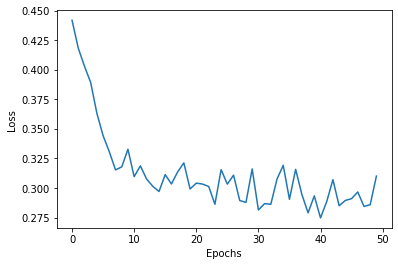

In [11]:
import numpy as np
import matplotlib.pyplot as plt
newLosses = []
for i in range(len(losses)):
  newLosses.append(losses[i].item())
nums = np.array(newLosses)
# plt.figure(figsize=(12.5,5))

# plt.subplot(121)
x = np.arange(0,len(nums))
plt.plot(x, nums)
# plt.plot([int(nums.size*0.10),int(nums.size*0.10)],[0,nums[0]], linestyle=':', label='10% cut-off line')
#plt.title('line chart')
plt.xlabel('Epochs')
plt.ylabel('Loss')
# plt.legend(loc=1,ncol=2) 
# plt.subplot(122)
# x = np.arange(0,len(new_nums))
# plt.plot(x, new_nums)
# plt.plot([int(new_nums.size*0.10),int(new_nums.size*0.10)],[0,new_nums[0]], linestyle=':', label='10% cut-off line')
# #plt.title('line chart')
# plt.xlabel('repository\'s id')
# plt.ylabel('in-degree ratio')
# plt.legend(loc=1,ncol=2) 

# plt.show()
plt.savefig('RGCNLoss.jpg', dpi=500, bbox_inches="tight")

NameError: ignored

In [5]:
train_data = generate_sampled_graph_and_labels(train_triplets, 410781, 0.5, len(entity2id), len(relation2id), args.negative_sample)


In [5]:
# train_triplets
train_triplets[0]
edge_index = [[],[]]
m = 0
for i in range(len(train_triplets)):
  edge_index[0].append(train_triplets[i][0])
  edge_index[1].append(train_triplets[i][2])
  m = max(edge_index[0][-1],m)
  m = max(edge_index[1][-1],m)
entity = []
for i in range(m):
  entity.append(i)

edge_index = torch.tensor(edge_index, dtype = torch.long)
entity = torch.tensor(entity, dtype = torch.long)
device = torch.device('cuda')
edge_index.to(device)
entity.to(device)

train_data.edge_type.to(device)
train_data.edge_norm.to(device)

NameError: ignored

In [6]:
    train_data = generate_sampled_graph_and_labels(train_triplets, 60000, 0.5, len(entity2id), len(relation2id), args.negative_sample)

    if use_cuda:
        device = torch.device('cuda')
        train_data.to(device)

    entity_embedding = model(train_data.entity, train_data.edge_index, train_data.edge_type, train_data.edge_norm)

In [1]:
train_data.entity[23184]

NameError: name 'train_data' is not defined

In [7]:
devVec = []
projectVec = []
devSet = set()
projectSet = set()
for k in entity2id:
  if len(k) == 9 and k[0] == '5':
    devSet.add(entity2id[k])
  else:
    projectSet.add(entity2id[k])
print(len(devSet))
print(len(projectSet))


for i in range(len(train_data.entity)):
  if train_data.entity[i].item() in devSet:
    devVec.append(entity_embedding[i].tolist())
  else:
    projectVec.append(entity_embedding[i].tolist())

2086
57285


In [8]:
from sklearn.decomposition import PCA
import numpy as np
from sklearn.preprocessing import StandardScaler

show_P = []
show_D = []
num = 200
data = devVec[:200]+projectVec[:200]  

# feature normalization (feature scaling)
X_scaler = StandardScaler()
x = X_scaler.fit_transform(data)

# PCA
pca = PCA(n_components=2)# 保证降维后的数据保持90%的信息
pca.fit(x)
xy = pca.transform(x)     

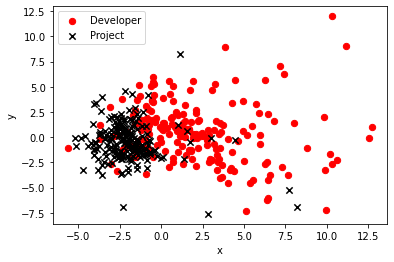

In [9]:
import matplotlib.pyplot as plt
plt.scatter(xy[:num, 0], xy[:num, 1], c='red', marker = 'o', s=40, cmap=plt.cm.Spectral, label='Developer')#c--color，s--size,marker点的形状
plt.scatter(xy[num:, 0], xy[num:, 1], c='black', marker = 'x', s=40, cmap=plt.cm.Spectral, label='Project')#c--color，s--size,marker点的形状
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.savefig('RGCN.jpg', dpi=500, bbox_inches="tight")
